In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/SARS_COVID_DATASET',
    labels="inferred",
    color_mode="grayscale",
    batch_size=16,
    image_size=(500, 500),
    shuffle=True,
    seed=None,
)

Found 2491 files belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ds_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3,
    rotation_range = 0,
    width_shift_range = 0,
    height_shift_range = 0,
    rescale = None,
    shear_range = 0,
    zoom_range = 0,
    horizontal_flip = False,
    fill_mode = 'nearest'
)

train_ds = ds_gen.flow_from_directory(
  "/content/drive/MyDrive/SARS_COVID_DATASET", 
  seed=1,
  target_size=(256, 256), #adjust to your needs
  batch_size=32,#adjust to your needs
  class_mode='categorical',
  subset='training',
  color_mode = "rgb",
  shuffle = True
)

val_ds = ds_gen.flow_from_directory(
  "/content/drive/MyDrive/SARS_COVID_DATASET",
  seed=1,
  target_size=(256, 256),
  batch_size=32,
  class_mode='categorical',
  subset='validation',
  color_mode = "rgb",
  shuffle = True
)
test_ds = ds_gen.flow_from_directory(
  "/content/drive/MyDrive/SARS_COVID_DATASET",
  seed=1,
  target_size=(256, 256),
  batch_size=32,
  class_mode='categorical',
  subset='validation',
  color_mode = "rgb",
  shuffle = True
)

Found 1745 images belonging to 2 classes.
Found 746 images belonging to 2 classes.
Found 746 images belonging to 2 classes.


Ensemble

In [ ]:
#layer 1 of cnn:
nets = 8
model = [0] *nets
for j in range(nets):
    #layer 1 of cnn:
    model[j] = keras.Sequential()
    model[j].add(Conv2D(32, kernel_size = 3,kernel_initializer='he_normal',activation='relu', input_shape = (256, 256, 3),kernel_regularizer=regularizers.l2(l=0.01)))
    model[j].add(MaxPooling2D((2, 2)))# Hidden Layer 2
    model[j].add(Conv2D(32, kernel_size = 5, activation='relu',kernel_constraint=unit_norm()))
    model[j].add(BatchNormalization())
    model[j].add(MaxPooling2D((2, 2)))# Hidden Layer 2
    model[j].add(Conv2D(32, kernel_size = 3, strides=2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.6))

    #Second Layer of CNN
    model[j].add(Conv2D(64, kernel_size = 3,kernel_constraint=unit_norm() ,activation='relu'))
    #    model[j].add(BatchNormalization())
    model[j].add(MaxPooling2D((2, 2)))# Hidden Layer 2
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
    model[j].add(Dropout(0.4))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.6))

    #Third layer of CNN
    model[j].add(Conv2D(128, kernel_size = 4, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
    model[j].add(Dropout(0.5))
    model[j].add(MaxPooling2D((2, 2)))# Hidden Layer 2
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.5))

    #Output layer
    model[j].add(Dense(2, activation='softmax'))

    # Compile each model
    model[j].compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
early = EarlyStopping(monitor='val_loss', mode='min', patience=2,restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 1, verbose=1,factor=0.3, min_lr=0.00000001)
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train_ds.classes), train_ds.classes)
cw = dict(zip( np.unique(train_ds.classes), weights))
print(cw)

{0: 0.9869909502262444, 1: 1.01335656213705}


In [ ]:
for j in range(nets):
    print(f'Individual Net : {j+1}')
    model[j].fit(train_ds,epochs=10, validation_data=val_ds, callbacks=callbacks_list,class_weight=cw)

Individual Net : 1
Epoch 1/10
55/55 [==============================] - 20s 336ms/step - loss: 3.3554 - accuracy: 0.6166 - val_loss: 3.0163 - val_accuracy: 0.6059
Epoch 2/10
55/55 [==============================] - 18s 331ms/step - loss: 2.9723 - accuracy: 0.7427 - val_loss: 2.8666 - val_accuracy: 0.6568
Epoch 3/10
55/55 [==============================] - 18s 331ms/step - loss: 2.6493 - accuracy: 0.8097 - val_loss: 2.9291 - val_accuracy: 0.5308

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
55/55 [==============================] - 18s 328ms/step - loss: 2.4360 - accuracy: 0.8436 - val_loss: 2.8071 - val_accuracy: 0.5724
Epoch 5/10
55/55 [==============================] - 18s 329ms/step - loss: 2.3315 - accuracy: 0.8527 - val_loss: 2.7172 - val_accuracy: 0.5737
Epoch 6/10
55/55 [==============================] - 18s 326ms/step - loss: 2.2469 - accuracy: 0.8619 - val_loss: 2.8342 - val_accuracy: 0.5094

Epoch 00006: ReduceLROnPlateau reducing l

In [ ]:
for j in range(nets):
    model[j].save('ensemble_3.h5')

In [ ]:
import tensorflow as tensorflow
model = tensorflow.keras.models.load_model('ensemble_3.h5')
model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_315 (Conv2D)          (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_180 (MaxPoolin (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_316 (Conv2D)          (None, 123, 123, 32)      25632     
_________________________________________________________________
batch_normalization_225 (Bat (None, 123, 123, 32)      128       
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_317 (Conv2D)          (None, 31, 31, 32)        9248      
_________________________________________________________________
batch_normalization_226 (Bat (None, 31, 31, 32)      

In [ ]:
train_accu = model.evaluate(train_ds)
print('The training accuracy is :',train_accu[1]*100, '%')

55/55 [==============================] - 13s 220ms/step - loss: 1.3908 - accuracy: 0.8682
The training accuracy is : 86.81948184967041 %


In [ ]:
train_accu

[1.3908257484436035, 0.8681948184967041]

In [ ]:
test_accu= model.evaluate(test_ds)
print('The test accuracy is :',test_accu[1]*100, '%')

24/24 [==============================] - 5s 223ms/step - loss: 1.4580 - accuracy: 0.8217
The test accuracy is : 82.17158317565918 %


In [ ]:
test_accu

[1.4580395221710205, 0.8217158317565918]

In [ ]:
#layer 1 of cnn:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential()
model.add(Conv2D(32, kernel_size = 3,kernel_initializer='he_normal',activation='relu', input_shape = (256, 256, 3),kernel_regularizer=regularizers.l2(l=0.01)))
model.add(MaxPooling2D((2, 2)))# Hidden Layer 2
model.add(Conv2D(32, kernel_size = 5, activation='relu',kernel_constraint=unit_norm()))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))# Hidden Layer 2
model.add(Conv2D(32, kernel_size = 3, strides=2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.6))

#Second Layer of CNN
model.add(Conv2D(64, kernel_size = 3,kernel_constraint=unit_norm() ,activation='relu'))
#    model[j].add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))# Hidden Layer 2
model.add(Conv2D(64, kernel_size = 3, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

#Third layer of CNN
model.add(Conv2D(128, kernel_size = 4, activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dropout(0.5))
model.add(MaxPooling2D((2, 2)))# Hidden Layer 2
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))

#Output layer
model.add(Dense(2, activation='softmax'))

# Compile each model
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
hist_model = model.fit(train_ds,epochs=40, validation_data=val_ds, callbacks=callbacks_list,class_weight=cw)

Epoch 1/40
55/55 [==============================] - 21s 353ms/step - loss: 3.3029 - accuracy: 0.6258 - val_loss: 2.9581 - val_accuracy: 0.6555
Epoch 2/40
55/55 [==============================] - 19s 348ms/step - loss: 2.9114 - accuracy: 0.7467 - val_loss: 3.0195 - val_accuracy: 0.4933

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 3/40
55/55 [==============================] - 19s 343ms/step - loss: 2.6266 - accuracy: 0.8069 - val_loss: 2.8892 - val_accuracy: 0.5174
Epoch 4/40
55/55 [==============================] - 19s 345ms/step - loss: 2.5028 - accuracy: 0.8436 - val_loss: 2.7158 - val_accuracy: 0.6836
Epoch 5/40
55/55 [==============================] - 19s 346ms/step - loss: 2.3907 - accuracy: 0.8556 - val_loss: 2.5496 - val_accuracy: 0.6944
Epoch 6/40
55/55 [==============================] - 19s 343ms/step - loss: 2.3045 - accuracy: 0.8613 - val_loss: 2.3639 - val_accuracy: 0.7413
Epoch 7/40
55/55 [==============================] - 19s 348ms

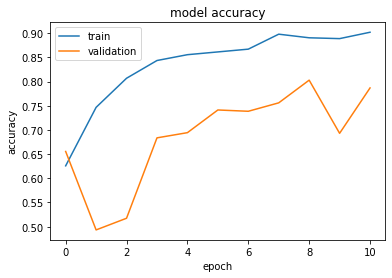

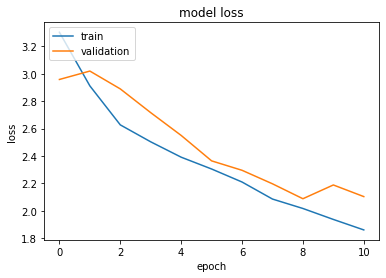

In [ ]:
plt.plot(hist_model.history['accuracy'])
plt.plot(hist_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(hist_model.history['loss'])
plt.plot(hist_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
train_accu = model.evaluate(train_ds)
print('The training accuracy is :',train_accu[1]*100, '%')

55/55 [==============================] - 12s 223ms/step - loss: 1.9804 - accuracy: 0.9117
The training accuracy is : 91.17478728294373 %


In [ ]:
test_accu = model.evaluate(test_ds)
print('The testing accuracy is :',test_accu[1]*100, '%')

24/24 [==============================] - 5s 225ms/step - loss: 2.0875 - accuracy: 0.8029
The testing accuracy is : 80.2949070930481 %


In [ ]:
model.save('CNN.h5')